In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Set random seed for reproducibility
# manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


from PIL import UnidentifiedImageError

class LegoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, self.image_list[index])
        try:
            image = Image.open(img_name).convert("RGB")
        except (UnidentifiedImageError, OSError):
            # If the image cannot be opened or is truncated, return a dummy image
            dummy_image = Image.new("RGB", (64, 64))
            if self.transform is not None:
                dummy_image = self.transform(dummy_image)
            return dummy_image

        if self.transform is not None:
            image = self.transform(image)

        return image


# Set the path to your dataset folder
data_path = "minifig_images"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the dataset and data loader
dataset = LegoDataset(root_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)


class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


# Hyperparameters
nz = 100  # Size of the latent vector (noise)
ngf = 128  # Number of generator filters
ndf = 128  # Number of discriminator filters
nc = 3    # Number of image channels

# Initialize models and move them to the CPU
device = torch.device("cpu")
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# Binary Cross Entropy loss function
criterion = nn.BCELoss()

# Optimizers for generator and discriminator
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))


num_epochs = 1
output_dir = "minifig_output/Trial_4"
os.makedirs(output_dir, exist_ok=True)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_images = data.to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size, 1, 1, 1), 1.0, device=device)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        output_real = netD(real_images)
        errD_real = criterion(output_real, label)
        errD_real.backward()
        D_x = output_real.mean().item()

        fake_images = netG(noise)
        label.fill_(0.0)
        output_fake = netD(fake_images.detach())
        errD_fake = criterion(output_fake, label)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(1.0)  # fake labels are real for generator cost
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}] "
                f"Loss_D: {errD.item():.4f} "
                f"Loss_G: {errG.item():.4f} "
                f"D(x): {D_x:.4f} "
                f"D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}"
            )

    # Save generated images after each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(
            fake, f"{output_dir}/fake_samples_epoch_{epoch + 1}.png",
            normalize=True,
        )

# Save the final generator model
torch.save(netG.state_dict(), "models/dcgan_generator_v4.pth")

Random Seed:  3326
[0/1] Loss_D: 1.3295 Loss_G: 6.1394 D(x): 0.5214 D(G(z)): 0.4819/0.0023


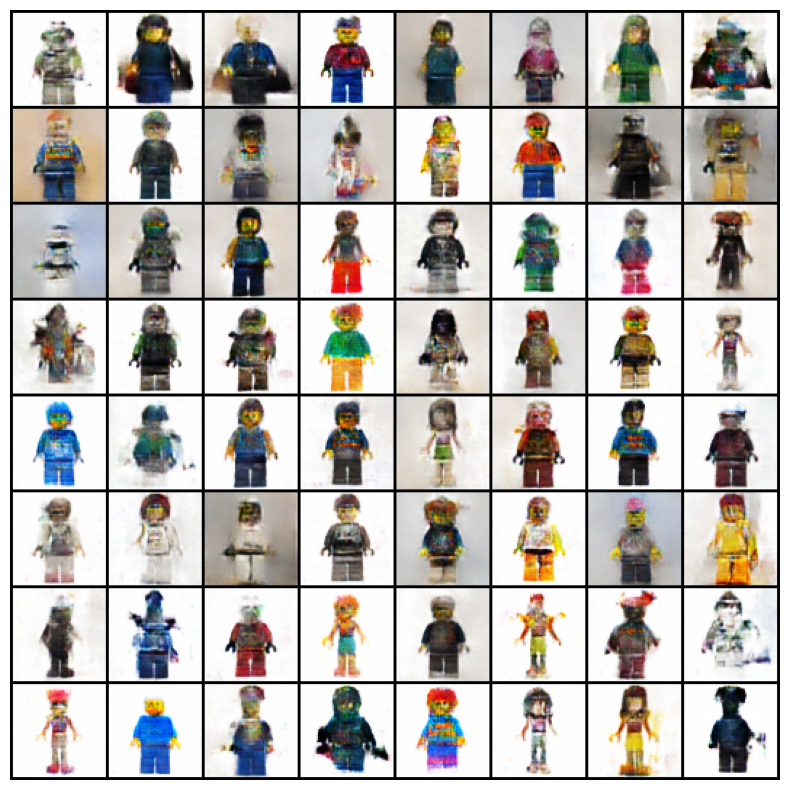

In [29]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Define image transformations for visualization
transform_vis = transforms.Compose([
    transforms.Normalize((0, 0, 0), (1, 1, 1)),  # Denormalize the generated images
    transforms.ToPILImage()  # Convert tensors to PIL images
])

# Load the Generator model
nz = 100  # Size of the latent vector (noise)
ngf = 64  # Number of generator filters
nc = 3    # Number of image channels

device = torch.device("cpu")  # Use the CPU for generating images
netG = Generator(nz, ngf, nc).to(device)
netG.load_state_dict(torch.load("../models/dcgan_generator.pth", map_location=device))
netG.eval()  # Set the model to evaluation mode

# Generate and visualize images
num_images_to_generate = 64  # Change this value to generate more or fewer images
fixed_noise = torch.randn(num_images_to_generate, nz, 1, 1, device=device)

with torch.no_grad():
    generated_images = netG(fixed_noise).detach().cpu()

# Display the generated images
grid = vutils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(transform_vis(grid))
plt.axis("off")
plt.show()


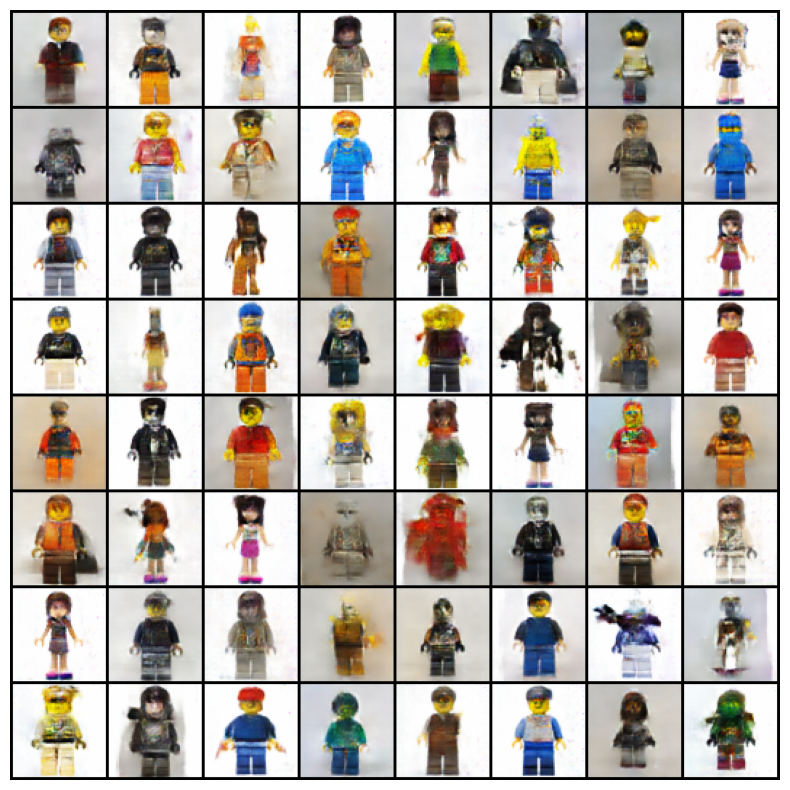

In [12]:
# Use to generate unlimited images :)

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

transform_vis = transforms.Compose([
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
    transforms.ToPILImage()
])

nz = 100  # Size of the latent vector (noise)
ngf = 128  # Number of generator filters
nc = 3    # Number of image channels

device = torch.device("cpu")
netG = Generator(nz, ngf, nc).to(device)
netG.load_state_dict(torch.load("models/dcgan_generator_v4.pth", map_location=device))
netG.eval()

num_images_to_generate = 64
fixed_noise = torch.randn(num_images_to_generate, nz, 1, 1, device=device)

with torch.no_grad():
    generated_images = netG(fixed_noise).detach().cpu()

grid = vutils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(transform_vis(grid))
plt.axis("off")
plt.show()